In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('./gdrive/My Drive/Colab Notebooks/growth_hackers')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


https://www.edwith.org/datait/lecture/53656/

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
import matplotlib.style as style
style.use('fivethirtyeight')

# 2) GH사가 광고를 첨부하고자 한다면, 어떤 영상에 하는 것이 좋을까요?
- 대다수의 고객이 27, 1110, 1995번 영상을 시청함
- 가능한 적은 비용으로 많은 광고 도달을 목표로 한다
- 광고비는 views에 비례한다
- 변수간의 관계에 집중


1) 사용자 기반 CF는 사용자 중심으로 유사도를 계산하는 것이고

(사용자 A와 사용자 B가 유사하다 -> A가 좋아했다면 B도 좋아할 것이다 -> B에게 A가 좋아하는 것을 추천해주자)

2) 아이템 기반 CF는 아이템 중심으로 유사로를 계산하는 것이다.

(아이템 a와 아이템 b가 유사하다 -> 사용자 A가 a를 좋아했으니 비슷한 b도 좋아할 것이다 -> A에게 A가 좋아하는 것과 비슷한 것을 추천해주자)

2)를 선택:
video a is similar with video b
- -> most customers watched video a
- -> therefore, we recommend u video b

아이템: 영상에 대한 시청자들의 반응/ 영상 태그



한 영상에 1) 여러 태그가 붙여져있고 한 영상에 2) 여러 반응이 있을 수 있다

그래서 이 두개를 각각 아이템 기반 CF로 구현

# 1) Tags

세 개로 해서 각각하던 한꺼번에 하던 걔들간의 유사도

칼럼에 태그 하나씩 넣고
행에 비디오 넘버 넣고
그 태그가 있으면 0,1

In [0]:
ted=pd.read_csv('ted.csv')

In [0]:
ted=ted[['video_num','tags','views']]

In [0]:
# tag 값들을 예쁘게 바꿔주기
import re
from collections import Counter
ted['tags']=ted['tags'].apply(lambda row:(re.sub('[^\w,]','',row)).split(','))

In [177]:
ted['tags']

0       [children, creativity, culture, dance, educati...
1       [alternativeenergy, cars, climatechange, cultu...
2       [computers, entertainment, interfacedesign, me...
3       [MacArthurgrant, activism, business, cities, e...
4       [Africa, Asia, Google, demo, economics, global...
                              ...                        
2545    [TEDResidency, UnitedStates, community, family...
2546    [Mars, SouthAmerica, TEDFellows, astrobiology,...
2547    [AI, ants, fish, future, innovation, insects, ...
2548    [Internet, TEDx, UnitedStates, community, comp...
2549    [cities, design, future, infrastructure, play,...
Name: tags, Length: 2550, dtype: object

In [178]:
'''
ted['tags']=ted['tags'].apply(lambda row:(re.sub('[\'\[\]]','',row)).split(', '))
ted['tags']=ted['tags'].apply(lambda row:[i.replace('"','') for i in row])
#countvectorizer가 공백으로 잘라버리기 때문에, 공백을 _로 먼저 바꿔준다
ted['tags']=ted['tags'].apply(lambda row: [i.replace(' ','') for i in row])
ted['tags']=ted['tags'].apply(lambda row: [i.lower() for i in row])
ted['tags']=ted['tags'].apply(lambda row: [i.strip() for i in row])
'''

'\nted[\'tags\']=ted[\'tags\'].apply(lambda row:(re.sub(\'[\'\\[\\]]\',\'\',row)).split(\', \'))\nted[\'tags\']=ted[\'tags\'].apply(lambda row:[i.replace(\'"\',\'\') for i in row])\n#countvectorizer가 공백으로 잘라버리기 때문에, 공백을 _로 먼저 바꿔준다\nted[\'tags\']=ted[\'tags\'].apply(lambda row: [i.replace(\' \',\'\') for i in row])\nted[\'tags\']=ted[\'tags\'].apply(lambda row: [i.lower() for i in row])\nted[\'tags\']=ted[\'tags\'].apply(lambda row: [i.strip() for i in row])\n'

# tf-idf vs countvectorizer

- tf idf는 countvectorizer+  각 단어 별 등장 횟수를 고려해서 가중치를 둔 것 
- 어차피 0,1로 하는 거니까 가중치는 고려x


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
#countvectorizer
alltags=[]
for i in ted['tags']:
  for j in i:
    alltags.append(j)
alltags=sorted(list(set(alltags)))


In [180]:
vectorizer = CountVectorizer()
vectorizer.fit(alltags)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
from collections import OrderedDict

vocab=dict(vectorizer.vocabulary_)
vocab=OrderedDict(sorted(vocab.items(), key= lambda t: t[0]))
#print(vocab)

col_names=[]
for k,v in vocab.items():
  col_names.append(k)

In [182]:
len(vocab)==len(alltags)

True

In [0]:
#각 비디오에 대해서 전체 태그 사전에서 있으면 1 아니면 0
def sumit(df,idx):
  new=pd.DataFrame(vectorizer.transform(df).toarray(), columns=col_names)
  new=pd.DataFrame(new.sum(axis=0)).T
  new['video_num']=idx
  new=new.set_index('video_num')
  return new

In [0]:
tag_ox=pd.DataFrame()
for i in range(len(ted)):
  df= sumit(ted['tags'].iloc[i],ted['video_num'].iloc[i])
  tag_ox=pd.concat([tag_ox,df])


In [185]:
tag_ox.head()

,3dprinting,activism,addiction,adventure,advertising,africa,aging,agriculture,ai,aids,aircraft,algorithm,alternativeenergy,alzheimers,ancientworld,animals,animation,anthropocene,anthropology,ants,apes,archaeology,architecture,art,asia,asteroid,astrobiology,astronomy,atheism,augmentedreality,autismspectrumdisorder,bacteria,beauty,bees,behavioraleconomics,bigbang,bigproblems,biodiversity,bioethics,biology,...,telescopes,television,terrorism,testing,theater,time,toy,trafficking,transgender,transportation,travel,trees,trust,typography,unitedstates,universe,urban,urbanplanning,vaccines,violence,violin,virtualreality,virus,visualizations,vocals,vulnerability,war,water,weather,web,wikipedia,windenergy,women,womeninbusiness,work,worklifebalance,worldcultures,writing,wunderkind,youth
video_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
tag_ox=tag_ox.T

In [187]:
tag_ox.head()

video_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550
3dprinting,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
activism,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
addiction,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
adventure,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
advertising,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# tag에서는 어떤 유사도를 쓸지?
- 코사인 유사도
- 자카드 유사도

### (1) 자카드 유사도

In [0]:
#유사한 아이템을 추천해주고 싶음-> 유사한 비디오를 보자->tag가 있냐 없냐를 기준으로
# 각 비디오 간의 유사도 구하기 -> jaccard

from sklearn.metrics.pairwise import pairwise_distances
jac_sim = 1 - pairwise_distances(tag_ox.T, metric = "hamming")
# optionally convert it to a DataFrame
jac_sim = pd.DataFrame(jac_sim, index=tag_ox.columns, columns=tag_ox.columns)

In [189]:
jac_sim.head()

video_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550
video_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.966346,0.961538,0.961538,0.956731,0.971154,0.966346,0.975962,0.961538,0.968750,0.963942,0.963942,0.963942,0.973558,0.973558,0.968750,0.973558,0.963942,0.966346,0.968750,0.971154,0.968750,0.968750,0.968750,0.966346,0.966346,0.963942,0.973558,0.966346,0.968750,0.966346,0.968750,0.963942,0.956731,0.963942,0.973558,0.959135,0.959135,0.966346,0.963942,...,0.971154,0.966346,0.973558,0.961538,0.966346,0.963942,0.968750,0.968750,0.968750,0.966346,0.954327,0.959135,0.975962,0.959135,0.975962,0.973558,0.978365,0.954327,0.961538,0.959135,0.956731,0.971154,0.956731,0.956731,0.971154,0.968750,0.971154,0.968750,0.966346,0.971154,0.959135,0.973558,0.959135,0.951923,0.959135,0.963942,0.961538,0.961538,0.966346,0.961538
2,0.966346,1.000000,0.961538,0.961538,0.956731,0.966346,0.961538,0.971154,0.956731,0.963942,0.963942,0.963942,0.973558,0.973558,0.968750,0.963942,0.963942,0.968750,0.956731,0.968750,0.975962,0.959135,0.963942,0.968750,0.966346,0.985577,0.963942,0.968750,0.961538,0.968750,0.961538,0.973558,0.968750,0.966346,0.959135,0.973558,0.959135,0.954327,0.975962,0.963942,...,0.961538,0.961538,0.963942,0.956731,0.961538,0.959135,0.963942,0.968750,0.968750,0.961538,0.959135,0.959135,0.966346,0.954327,0.966346,0.963942,0.968750,0.954327,0.961538,0.954327,0.961538,0.966346,0.956731,0.961538,0.975962,0.963942,0.966346,0.963942,0.961538,0.966346,0.959135,0.973558,0.954327,0.951923,0.954327,0.959135,0.961538,0.961538,0.961538,0.956731
3,0.961538,0.961538,1.000000,0.956731,0.951923,0.966346,0.961538,0.966346,0.956731,0.959135,0.954327,0.959135,0.963942,0.978365,0.963942,0.978365,0.978365,0.963942,0.956731,0.968750,0.966346,0.968750,0.968750,0.959135,0.966346,0.961538,0.959135,0.963942,0.961538,0.959135,0.956731,0.968750,0.963942,0.951923,0.954327,0.968750,0.949519,0.954327,0.961538,0.963942,...,0.966346,0.961538,0.968750,0.956731,0.961538,0.959135,0.973558,0.968750,0.968750,0.966346,0.959135,0.954327,0.966346,0.954327,0.966346,0.963942,0.968750,0.954327,0.956731,0.954327,0.951923,0.966346,0.956731,0.951923,0.966346,0.963942,0.966346,0.963942,0.961538,0.966346,0.954327,0.968750,0.954327,0.947115,0.954327,0.959135,0.956731,0.956731,0.961538,0.961538
4,0.961538,0.961538,0.956731,1.000000,0.951923,0.966346,0.956731,0.966346,0.956731,0.959135,0.959135,0.954327,0.959135,0.968750,0.959135,0.963942,0.963942,0.963942,0.956731,0.963942,0.966346,0.954327,0.963942,0.959135,0.956731,0.961538,0.959135,0.973558,0.961538,0.959135,0.961538,0.963942,0.959135,0.951923,0.959135,0.968750,0.959135,0.959135,0.956731,0.963942,...,0.961538,0.966346,0.968750,0.956731,0.966346,0.959135,0.963942,0.968750,0.963942,0.961538,0.949519,0.954327,0.966346,0.963942,0.966346,0.968750,0.963942,0.959135,0.951923,0.959135,0.956731,0.966346,0.956731,0.956731,0.971154,0.973558,0.971154,0.963942,0.966346,0.966346,0.963942,0.968750,0.959135,0.947115,0.954327,0.959135,0.956731,0.956731,0.966346,0.961538
5,0.956731,0.956731,0.951923,0.951923,1.000000,0.956731,0.951923,0.961538,0.951923,0.954327,0.954327,0.954327,0.963942,0.968750,0.959135,0.959135,0.959135,0.959135,0.951923,0.954327,0.961538,0.954327,0.954327,0.954327,0.956731,0.956731,0.954327,0.963942,0.956731,0.954327,0.956731,0.963942,0.954327,0.951923,0.959135,0.963942,0.959135,0.949519,0.956731,0.963942,...,0.956731,0.956731,0.959135,0.951923,0.956731,0.959135,0.959135,0.959135,0.959135,0.956731,0.949519,0.954327,0.966346,0.954327,0.966346,0.959135,0.959135,0.944712,0.947115,0.949519,0.942308,0.961538,0.947115,0.942308,0.961538,0.963942,0.961538,0.959135,0.961538,0.966346,0.959135,0.963942,0.954327,0.947115,0.954327


### (2) cosine 유사도

In [190]:
target=ted.loc[(ted['video_num']==27) | (ted['video_num']==1110)| (ted['video_num']==1995)]
target

,video_num,tags,views
26,27,"[astronomy, biology, cognitivescience, cosmos,...",2885999
1109,1110,"[DNA, TEDx, biology, biotech, computers, genet...",1443353
1994,1995,"[animals, biology, brain, cognitivescience, co...",2471075


In [191]:
len(tag_ox)

416

In [0]:
#이렇게 하면 세개의 태그가 모두 타겟 태그와 일치 했을 때 가장 유사도가 높오는 것을 방지
#전체 태그 개수로 나눠줘서 한번 더 보정
tag_ox=tag_ox.T
ted['total']=ted['tags'].apply(lambda row:len(row))
df=ted[['video_num','total']]
tag_ox=pd.merge(tag_ox,df, on='video_num')
tag_ox=tag_ox.set_index('video_num')

tag_ox=tag_ox.apply(lambda row: row/tag_ox['total'])  #total로 나눠주기
del df, tag_ox['total']

In [193]:
tag_ox.head()

,3dprinting,activism,addiction,adventure,advertising,africa,aging,agriculture,ai,aids,aircraft,algorithm,alternativeenergy,alzheimers,ancientworld,animals,animation,anthropocene,anthropology,ants,apes,archaeology,architecture,art,asia,asteroid,astrobiology,astronomy,atheism,augmentedreality,autismspectrumdisorder,bacteria,beauty,bees,behavioraleconomics,bigbang,bigproblems,biodiversity,bioethics,biology,...,telescopes,television,terrorism,testing,theater,time,toy,trafficking,transgender,transportation,travel,trees,trust,typography,unitedstates,universe,urban,urbanplanning,vaccines,violence,violin,virtualreality,virus,visualizations,vocals,vulnerability,war,water,weather,web,wikipedia,windenergy,women,womeninbusiness,work,worklifebalance,worldcultures,writing,wunderkind,youth
video_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#유사한 아이템을 추천해주고 싶음-> 유사한 비디오를 보자->reaction을 기준으로
# 각 비디오 간의 유사도 구하기 -> cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
#print(cosine_similarity(reaction).shape)
tag_ox=pd.DataFrame(cosine_similarity(tag_ox))

In [195]:
tag_ox

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549
0,1.000000,0.125988,0.000000,0.000000,0.000000,0.142857,0.125988,0.169031,0.0,0.133631,0.119523,0.119523,0.000000,0.000000,0.267261,0.000000,0.154303,0.000000,0.125988,0.133631,0.142857,0.239046,0.133631,0.133631,0.125988,0.125988,0.000000,0.154303,0.125988,0.133631,0.125988,0.000000,0.000000,0.104828,0.119523,0.154303,0.109109,0.000000,0.125988,0.000000,...,0.142857,0.000000,0.154303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.169031,0.000000,0.169031,0.154303,0.308607,0.000000,0.113961,0.000000,0.104828,0.000000,0.000000,0.104828,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.125988,1.000000,0.111111,0.111111,0.100504,0.125988,0.111111,0.149071,0.0,0.117851,0.210819,0.210819,0.353553,0.166667,0.235702,0.000000,0.000000,0.235702,0.000000,0.235702,0.377964,0.105409,0.117851,0.235702,0.222222,0.666667,0.117851,0.136083,0.111111,0.235702,0.111111,0.272166,0.235702,0.369800,0.105409,0.272166,0.192450,0.000000,0.444444,0.117851,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136083,0.136083,0.000000,0.192450,0.105409,0.000000,0.000000,0.000000,0.000000,0.136083,0.096225,0.201008,0.000000,0.277350,0.000000,0.100504,0.277350,0.298142,0.000000,0.000000,0.0,0.000000,0.000000,0.105409,0.166667,0.000000,0.092450,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000
2,0.000000,0.111111,1.000000,0.000000,0.000000,0.125988,0.111111,0.000000,0.0,0.000000,0.000000,0.105409,0.117851,0.333333,0.117851,0.408248,0.408248,0.117851,0.000000,0.235702,0.125988,0.316228,0.235702,0.000000,0.222222,0.111111,0.000000,0.000000,0.111111,0.000000,0.000000,0.136083,0.117851,0.092450,0.000000,0.136083,0.000000,0.000000,0.111111,0.117851,...,0.125988,0.000000,0.136083,0.000000,0.000000,0.000000,0.272166,0.136083,0.136083,0.125988,0.192450,0.000000,0.000000,0.000000,0.000000,0.000000,0.136083,0.096225,0.100504,0.000000,0.092450,0.000000,0.100504,0.092450,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
3,0.000000,0.111111,0.000000,1.000000,0.000000,0.125988,0.000000,0.000000,0.0,0.000000,0.105409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117851,0.000000,0.117851,0.125988,0.000000,0.117851,0.000000,0.000000,0.111111,0.000000,0.272166,0.111111,0.000000,0.111111,0.000000,0.000000,0.092450,0.105409,0.136083,0.192450,0.105409,0.000000,0.117851,...,0.000000,0.125988,0.136083,0.000000,0.125988,0.000000,0.000000,0.136083,0.000000,0.000000,0.000000,0.000000,0.000000,0.210819,0.000000,0.136083,0.000000,0.192450,0.000000,0.105409,0.184900,0.000000,0.100504,0.184900,0.149071,0.272166,0.149071,0.0,0.125988,0.000000,0.210819,0.000000,0.105409,0.000000,0.000000,0.000000,0.000000,0.000000,0.125988,0.111111
4,0.000000,0.100504,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.095346,0.095346,0.213201,0.150756,0.106600,0.000000,0.000000,0.106600,0.000000,0.000000,0.113961,0.095346,0.000000,0.000000,0.100504,0.100504,0.000000,0.123091,0.100504,0.000000,0.100504,0.123091,0.000000,0.167248,0.190693,0.123091,0.261116,0.000000,0.100504,0.213201,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.106600,0.000000,0.000000,0.000000,0.000000,0.087039,0.095346,0.134840,0.095346,0.134840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.123091,0.000000,0.0,0.113961,0.134840,0.190693,0.000000,0.095346,0.083624,0.095346,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [0]:
def show_df(videonum):
  idxnum=videonum-1
  result=pd.DataFrame(tag_ox[idxnum].sort_values(ascending=False)).reset_index().reset_index()
  return result

In [0]:
#https://frhyme.github.io/python-lib/subplot/

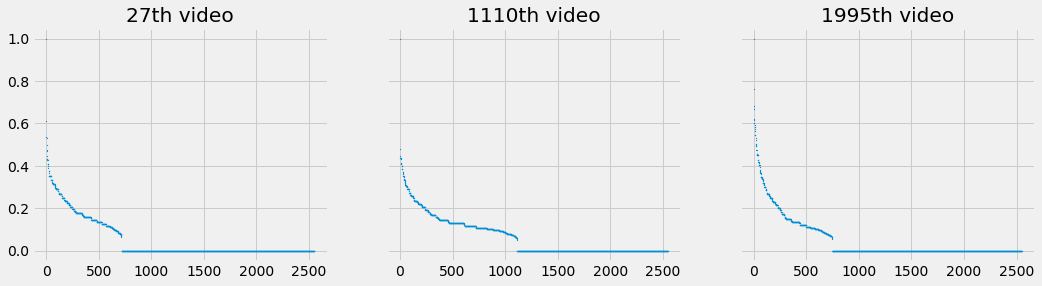

In [198]:
videolist=[27,1110,1995]
f, axes=plt.subplots(1,3,sharex=True, sharey=True)
f.set_size_inches((16,4))
for i in range(0,3):
  v=videolist[i-1]
  x=show_df(videolist[i])['level_0']
  y=show_df(videolist[i])[videolist[i]-1]
  df=show_df(videolist[i-1])
  axes[i].scatter(x,y,s=0.5)
  axes[i].set_title('{}th video'.format(videolist[i]))
plt.show()

### target video들에 대해서, 유사도의 분포를 알아보고, 이를 반영하여 유사도 몇 %까지 잘라서 그룹으로 만들것인지를 살펴보았다

- 플랏을 보고 0.2에서 자르기로 했다
- 유사도 0.2 이상인 애들을 뽑아서 진짜 비슷한지 확인해보자

In [0]:
#상위 열개만 일단 뽑아보고 진짜 비슷한지 확인해보기
# 전체 태그 중에서 타겟 태그를 몇개 포함하는 지 비율보기
def really(videonum):
  idxnum=videonum-1  # 실제 인덱스는 비디오 넘버-1이다
  group=pd.DataFrame(tag_ox[idxnum].loc[tag_ox[idxnum]>0.2].sort_values(ascending=False).reset_index())
  
  group['how_many']=np.nan
  group['total']=np.nan
  tt=[i for i in ted['tags'][idxnum]]
  see=[i for i in group.iloc[:,0]] #보고싶은 애들 인덱스 리스트
  
  for i in range(len(group)):       #보고싶은 애들의 인덱스-> ted에서 태그 가져오기
    cnt=0
    for t in tt:                 
      if t in ted.iloc[see[i]]['tags']:                  
        cnt+=1
      group['how_many'][i]=cnt

  for r,i in enumerate(see):
    group['total'][r]=sum(Counter(ted['tags'][i]).values())
    group['tag_portion']=group['how_many']/group['total'] ##target tag를 얼마나 가지고 있는 지, 비율
    group=group.sort_values(by='tag_portion', ascending=False)
  del group['how_many']
  return group

In [200]:
group1=really(27)
group1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,26,total,tag_portion
0,26,1.000000,8.0,1.000000
1,629,0.612372,3.0,1.000000
3,1003,0.530330,4.0,0.750000
16,950,0.408248,3.0,0.666667
15,1778,0.408248,3.0,0.666667
...,...,...,...,...
175,1339,0.237171,20.0,0.150000
196,2238,0.231455,21.0,0.142857
197,1281,0.226134,22.0,0.136364
214,2331,0.221163,23.0,0.130435


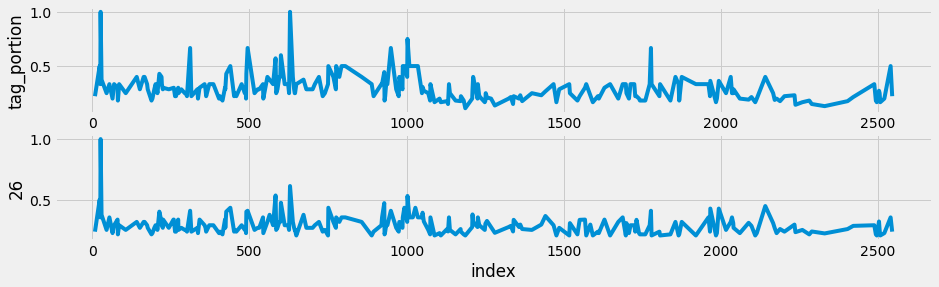

In [201]:
f, ax = plt.subplots(2,1,figsize=(14,4))
sns.lineplot('index','tag_portion', data=group1.sort_values(by='tag_portion').reset_index(), ax=ax[0])
sns.lineplot('index',26,data=group1.sort_values(by=26).reset_index(), ax=ax[1])

In [202]:
group2=really(1110)
group2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,1109,total,tag_portion
0,1109,1.000000,12.0,1.000000
8,1003,0.433013,4.0,0.750000
42,1103,0.333333,3.0,0.666667
41,1748,0.333333,3.0,0.666667
20,159,0.387298,5.0,0.600000
...,...,...,...,...
208,2451,0.210042,17.0,0.176471
162,1323,0.235702,24.0,0.166667
209,2359,0.204124,18.0,0.166667
210,1583,0.204124,18.0,0.166667


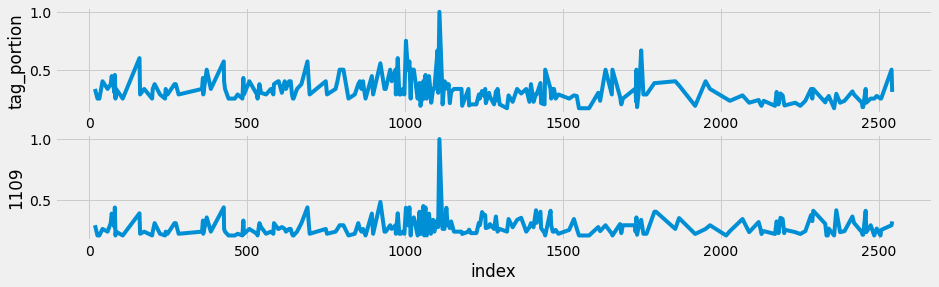

In [203]:
f, ax = plt.subplots(2,1,figsize=(14,4))
sns.lineplot('index','tag_portion', data=group2.sort_values(by='tag_portion').reset_index(), ax=ax[0])
sns.lineplot('index',1109,data=group2.sort_values(by=1109).reset_index(), ax=ax[1])

In [204]:
group3=really(1995)
group3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,1994,total,tag_portion
0,1994,1.000000,11.0,1.000000
6,805,0.603023,4.0,1.000000
2,583,0.683763,7.0,0.857143
5,2489,0.615457,6.0,0.833333
1,1568,0.762770,10.0,0.800000
...,...,...,...,...
210,1535,0.213201,18.0,0.166667
177,2386,0.241209,25.0,0.160000
228,1142,0.207514,19.0,0.157895
229,2156,0.207514,19.0,0.157895


In [205]:
group3.columns

Index(['index', 1994, 'total', 'tag_portion'], dtype='object')

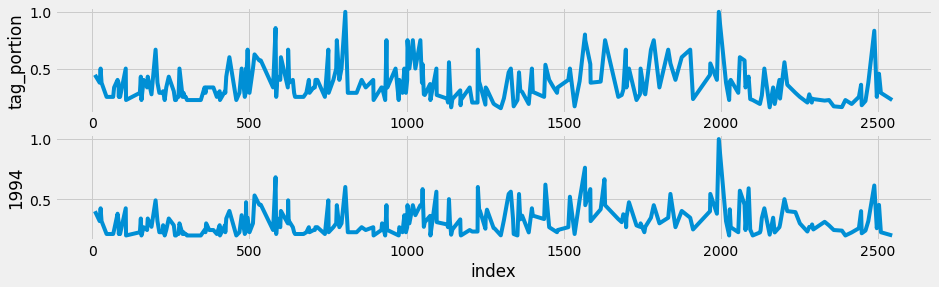

In [206]:
f, ax = plt.subplots(2,1,figsize=(14,4))
sns.lineplot('index','tag_portion', data=group3.sort_values(by='tag_portion').reset_index(), ax=ax[0])
sns.lineplot('index',1994,data=group3.sort_values(by=1994).reset_index(), ax=ax[1])

# 2) reaction

##### views로 각 반응값들 나누기 -> 각 리액션 칼럼에 대한 점수/평점이라고 생각
예를 들어, funny/views=0.5가 나왔으면 0.5만큼 재미있었다

https://lsjsj92.tistory.com/568?category=853217

https://yeomko.tistory.com/6
에서 보면,  

reaction: explicit data

tags: implicit data 

라는 것을 알 수 있다

In [0]:
ted=pd.read_csv('ted.csv')

In [0]:
#먼저 views로 각 반응들 나눠서 비율(평점) 칼럼만들기
for i,col in enumerate(ted.columns):
  if i >= 3 and i <=16:
    ted[col] = ted[col]/ted['views']
    
#정규화시켜주기
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler()
for i,col in enumerate(ted.columns):
  if i>=3 and i<16:
    ted[col]=pd.DataFrame(data=Scaler.fit_transform(ted[col].values.reshape(-1,1)),columns=[col])

In [0]:
reaction=ted.drop(['duration','comments','tags','views'], axis=1).set_index('video_num')

In [210]:
reaction.T.head()

video_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549,2550
Funny,0.092192,0.037510,0.130685,0.099246,0.059012,0.011570,0.027852,0.044518,0.048375,0.059894,0.030738,0.039844,0.060001,0.049473,0.051220,0.137173,0.150793,0.050129,0.053329,0.020619,0.026638,0.101036,0.034873,0.018450,0.128167,0.054242,0.025376,0.037381,0.052518,0.025877,0.033646,0.014399,0.020683,0.049172,0.018635,0.011590,0.037909,0.018138,0.023590,0.012409,...,0.014314,0.009379,0.009114,0.025042,0.011310,0.000494,0.059189,0.023671,0.021303,0.048816,0.006865,0.044319,0.029414,0.013456,0.007804,0.040044,0.032496,0.017992,0.006323,0.005946,0.000480,0.021110,0.005128,0.025678,0.015552,0.023910,0.017397,0.106347,0.017613,0.030500,0.005159,0.009542,0.016540,0.005131,0.004509,0.011571,0.016766,0.008012,0.001318,0.011644
Beautiful,0.014065,0.006149,0.003788,0.025124,0.016874,0.004878,0.097388,0.014723,0.003752,0.036437,0.031283,0.036402,0.018099,0.008774,0.036534,0.010133,0.007446,0.015418,0.006474,0.001452,0.007687,0.009052,0.030010,0.002544,0.019881,0.012145,0.005464,0.001937,0.023498,0.011478,0.002349,0.024316,0.009435,0.002949,0.010849,0.010429,0.004291,0.001903,0.054217,0.013738,...,0.032841,0.006684,0.015058,0.014283,0.021894,0.000734,0.028649,0.002826,0.003982,0.034754,0.010994,0.003377,0.005301,0.019416,0.005948,0.006489,0.024440,0.021366,0.003010,0.025460,0.007736,0.004613,0.029353,0.003888,0.002464,0.003690,0.006519,0.015724,0.012593,0.021639,0.008162,0.001968,0.011470,0.018559,0.012821,0.010572,0.013205,0.012339,0.001832,0.009172
Ingenious,0.013456,0.001950,0.011691,0.001895,0.008175,0.001829,0.008851,0.002740,0.011519,0.016106,0.001475,0.004255,0.001277,0.000700,0.005790,0.007316,0.012650,0.004895,0.018055,0.004289,0.002307,0.001196,0.017379,0.009738,0.010055,0.012491,0.004545,0.000608,0.004904,0.001638,0.012561,0.028438,0.011159,0.003257,0.002299,0.018227,0.006158,0.003181,0.006129,0.001668,...,0.027661,0.006390,0.012682,0.003572,0.006384,0.000000,0.002042,0.036721,0.005501,0.007937,0.001287,0.004396,0.011330,0.004294,0.003133,0.004887,0.006857,0.002245,0.000691,0.009857,0.011850,0.002759,0.021368,0.008391,0.008061,0.009286,0.013308,0.030604,0.001774,0.003705,0.026851,0.000390,0.006711,0.007985,0.007464,0.006224,0.004956,0.005238,0.015738,0.006902
Courageous,0.022972,0.005595,0.011944,0.011290,0.008459,0.004372,0.019823,0.011419,0.007390,0.012218,0.052238,0.017043,0.007291,0.003546,0.029966,0.003064,0.004014,0.066859,0.024890,0.051986,0.003642,0.003516,0.021175,0.012145,0.008767,0.012500,0.048858,0.003576,0.008652,0.009739,0.013084,0.091437,0.021847,0.110899,0.013951,0.041235,0.012506,0.013905,0.007660,0.048935,...,0.015670,0.019211,0.013848,0.015807,0.012198,0.069077,0.027112,0.041215,0.001987,0.008974,0.009977,0.029496,0.004770,0.013640,0.010521,0.025480,0.002932,0.003409,0.002565,0.012161,0.045144,0.008138,0.053772,0.017307,0.008398,0.025510,0.008462,0.229082,0.013164,0.017570,0.003294,0.019720,0.008864,0.019235,0.000209,0.000151,0.005131,0.026732,0.119413,0.009004
Longwinded,0.003207,0.036446,0.028618,0.027836,0.003651,0.015111,0.033170,0.011777,0.031082,0.044811,0.229811,0.005362,0.158326,0.009981,0.132671,0.023733,0.009308,0.166414,0.033205,0.025578,0.013694,0.009685,0.047237,0.011787,0.010395,0.037526,0.006125,0.027499,0.004674,0.004883,0.012159,0.016375,0.028293,0.138916,0.089242,0.020780,0.019298,0.016869,0.026546,0.016052,...,0.066230,0.075843,0.012576,0.002747,0.030720,0.048139,0.016701,0.074210,0.009887,0.020860,0.005450,0.003230,0.016754,0.019783,0.041578,0.063106,0.028529,0.010221,0.013065,0.040109,0.114363,0.010484,0.029895,0.077050,0.012231,0.021494,0.011608,0.027193,0.037115,0.030781,0.045800,0.063040,0.001986,0.004595,0.000543,0.023902,0.008241,0.001889,0.042137,0.009991


In [0]:
#유사한 아이템을 추천해주고 싶음-> 유사한 비디오를 보자->reaction을 기준으로
# 각 비디오 간의 유사도 구하기 -> cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
#print(cosine_similarity(reaction).shape)
reaction=pd.DataFrame(cosine_similarity(reaction))

In [212]:
reaction

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2531,2532,2533,2534,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544,2545,2546,2547,2548,2549
0,1.000000,0.849838,0.692699,0.420350,0.691917,0.296151,0.601737,0.823961,0.763408,0.793707,0.288107,0.352109,0.493976,0.423318,0.395517,0.604813,0.195549,0.325560,0.416076,0.688439,0.601721,0.580103,0.618090,0.788243,0.347522,0.762388,0.584154,0.570029,0.791153,0.705197,0.828526,0.797700,0.635629,0.413977,0.234782,0.824977,0.679435,0.807441,0.593126,0.878183,...,0.347406,0.397459,0.682794,0.681678,0.486683,0.512991,0.501431,0.562716,0.598751,0.525769,0.608165,0.543401,0.449755,0.740250,0.256067,0.413932,0.483874,0.508574,0.464977,0.392527,0.455230,0.530486,0.456621,0.498558,0.910327,0.872136,0.755794,0.447491,0.354440,0.403219,0.611551,0.513218,0.870750,0.683684,0.711080,0.785491,0.591984,0.539579,0.517514,0.512950
1,0.849838,1.000000,0.873854,0.586204,0.726037,0.465337,0.790108,0.915838,0.798303,0.804919,0.521132,0.565837,0.663383,0.393645,0.683926,0.412814,0.361072,0.461786,0.639968,0.769227,0.827686,0.692286,0.862552,0.860049,0.539156,0.848660,0.764876,0.793021,0.722710,0.706658,0.935865,0.928468,0.698995,0.610967,0.465905,0.859662,0.859833,0.922693,0.687588,0.823784,...,0.563503,0.485287,0.763667,0.574153,0.644694,0.647725,0.482149,0.792386,0.667264,0.593002,0.830198,0.435965,0.459465,0.812527,0.416811,0.599756,0.562695,0.653498,0.511581,0.591619,0.606471,0.519021,0.607248,0.773292,0.901540,0.883636,0.834966,0.444922,0.449164,0.407399,0.762014,0.649379,0.751311,0.574970,0.719546,0.780379,0.699918,0.620847,0.630688,0.612667
2,0.692699,0.873854,1.000000,0.664515,0.781200,0.460519,0.828810,0.880561,0.604466,0.626392,0.513027,0.594245,0.515774,0.306563,0.773944,0.388970,0.377048,0.505144,0.843333,0.559076,0.888510,0.795764,0.790486,0.700093,0.621683,0.637446,0.801423,0.824679,0.590441,0.656551,0.776470,0.883658,0.583497,0.615206,0.396691,0.649857,0.963385,0.708590,0.526203,0.632205,...,0.575212,0.264579,0.654929,0.546414,0.730132,0.529903,0.552463,0.717046,0.737144,0.747784,0.720528,0.456461,0.448100,0.767932,0.288704,0.585108,0.521700,0.710037,0.334147,0.471739,0.429629,0.504522,0.522503,0.758228,0.686467,0.645470,0.682784,0.439533,0.357761,0.355924,0.587651,0.607580,0.614816,0.527722,0.556002,0.528887,0.609289,0.565266,0.508208,0.667855
3,0.420350,0.586204,0.664515,1.000000,0.778034,0.941553,0.709497,0.566199,0.769650,0.588608,0.342845,0.521505,0.647950,0.459966,0.502597,0.158571,0.830306,0.344234,0.857859,0.263679,0.443645,0.462901,0.579163,0.493014,0.883886,0.432259,0.923520,0.720416,0.764965,0.865705,0.474353,0.507053,0.747356,0.586964,0.488126,0.407603,0.571733,0.640593,0.284462,0.547030,...,0.832039,0.192529,0.382341,0.529387,0.528589,0.318304,0.440386,0.418992,0.415839,0.521112,0.328279,0.348415,0.253171,0.697851,0.175340,0.302090,0.524788,0.906691,0.224917,0.357493,0.424007,0.378585,0.267831,0.598949,0.459636,0.414620,0.424539,0.194795,0.263464,0.200208,0.347271,0.395233,0.441261,0.491926,0.246119,0.425955,0.540848,0.243633,0.782449,0.816673
4,0.691917,0.726037,0.781200,0.778034,1.000000,0.593717,0.836944,0.798014,0.787694,0.837972,0.396951,0.467310,0.445685,0.482681,0.560822,0.292868,0.343371,0.423022,0.822560,0.367910,0.645565,0.569440,0.610745,0.723969,0.504160,0.619431,0.804588,0.535606,0.872035,0.927265,0.666726,0.767613,0.799474,0.425947,0.230298,0.520302,0.766193,0.715864,0.331279,0.825247,...,0.620023,0.272847,0.408033,0.521839,0.699351,0.366223,0.357735,0.402411,0.407978,0.567439,0.388689,0.306841,0.222834,0.884582,0.091256,0.252700,0.399333,0.763446,0.284727,0.198145,0.428973,0.228448,0.213099,0.468836,0.651928,0.511784,0.367661,0.139338,0.224044,0.142659,0.363098,0.500167,0.585494,0.687285,0.266553,0.594192,0.288996,0.169991,0.579532,0.668870
...,...,...,...,...,...,...,...,...,...,...,...,...,...

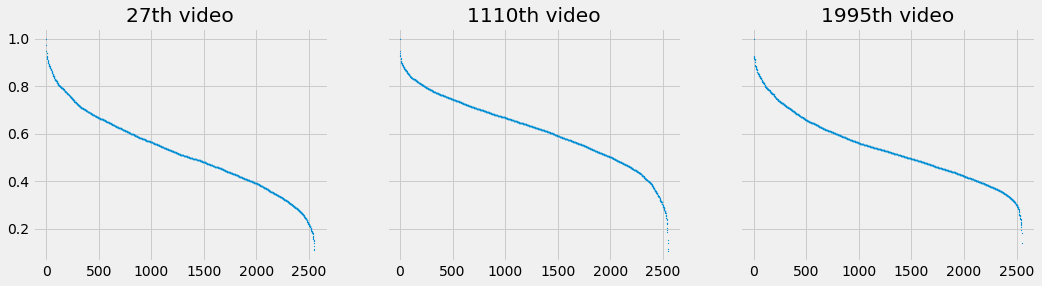

In [213]:
#그래프 그려서 비슷한지 보기
def show_df_r(videonum):
  idxnum=videonum-1
  result=pd.DataFrame(reaction[idxnum].sort_values(ascending=False)).reset_index().reset_index()
  return result


videolist=[27,1110,1995]
f, axes=plt.subplots(1,3,sharex=True, sharey=True)
f.set_size_inches((16,4))
for i in range(0,3):
  v=videolist[i-1]
  x=show_df_r(videolist[i])['level_0']
  y=show_df_r(videolist[i])[videolist[i]-1]
  df=show_df_r(videolist[i-1])
  axes[i].scatter(x,y,s=0.5)
  axes[i].set_title('{}th video'.format(videolist[i]))
plt.show()

In [0]:
#역시 분포가 비슷하니까 비슷하게 잘라도 되겠다

In [0]:
def grouping(videonum):
  idxnum=videonum-1  # 실제 인덱스는 비디오 넘버-1이다
  end=len(really(videonum))
  group=pd.DataFrame(reaction[idxnum].iloc[:end].sort_values(ascending=False).reset_index())
  return group

In [216]:
groupA=grouping(27)  #group1과 같은 수의 후보군집단으로 rerank
groupB=grouping(1110)
groupC=grouping(1995)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# 3)  교집합 리스트 구하고 최소의 views 비디오 데려오기

In [217]:
#27th video
Tlist=[i for i in group1['index']]
Rlist=[j for j in groupA['index']]
fin27=list(set(Tlist).intersection(set(Rlist)))
fin27=ted.iloc[fin27].sort_values(by='views').reset_index().iloc[0]
print(fin27['video_num'])

226


In [221]:
#1110
Tlist_1=[i for i in group2['index']]
Rlist_1=[j for j in groupB['index']]
fin1110=list(set(Tlist_1).intersection(set(Rlist_1)))
fin1110=ted.iloc[fin1110].sort_values(by='views').reset_index().iloc[0]
print(fin1110['video_num'])

160


In [219]:
#1995
Tlist_2=[i for i in group3['index']]
Rlist_2=[j for j in groupC['index']]
fin1995=list(set(Tlist_2).intersection(set(Rlist_2)))
fin1995=ted.iloc[fin1995].sort_values(by='views').reset_index().iloc[0]
print(fin1995['video_num'])

226


In [0]:
#함수...고민중,,,

In [223]:
ted.loc[(ted['video_num']==226)|(ted['video_num']==160)]

,video_num,duration,comments,Funny,Beautiful,Ingenious,Courageous,Longwinded,Confusing,Informative,Fascinating,Unconvincing,Persuasive,Jaw-dropping,OK,Obnoxious,Inspiring,tags,views
159,160,299,40,0.075526,0.070121,0.066882,0.053592,0.012861,0.034422,0.123025,0.018091,0.045695,0.015329,0.077349,0.204460,0.022082,0.000022,"['DNA', 'MacArthur grant', 'complexity', 'comp...",410563
225,226,1071,69,0.086107,0.084112,0.031089,0.108450,0.044036,0.020466,0.013860,0.016745,0.121627,0.018011,0.021963,0.085343,0.063724,0.000014,"['bacteria', 'biology', 'disease', 'evolution'...",442623
